In [8]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [9]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [10]:
import numpy as np
import pandas as pd
import warnings

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]


# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

# Função OBV ajustada
def obv(group, smoothed_col):
    Volume = group['Volume']
    change = group[smoothed_col].diff()
    prev_obv = 0
    obv_values = []
    for i, j in zip(change, Volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
        prev_obv = current_obv
        obv_values.append(current_obv)
    return pd.Series(obv_values, index=group.index)

# Lista de alphas e parâmetros gerais
alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08,0.09, 0.10, 0.20, 0.30, 0.40, 0.50, ]
n = 14
d = 60
t = 14
e = 27

# Loop para cálculos por alpha
for alpha in alpha_list:
    smoothed_col = f'Smoothed_Close_{alpha:.2f}'
    target_col = f'Prediction_{alpha:.2f}'
    obv_col = f'OBV_{alpha:.2f}'
    price_rate_col = f'Price_Rate_Of_Change_{alpha:.2f}'
    macd_col = f'MACD_{alpha:.2f}'
    macd_ema_col = f'MACD_EMA_{alpha:.2f}'
    low_col = f'low_{t}_{alpha:.2f}'
    high_col = f'high_{t}_{alpha:.2f}'
    k_percent_col = f'k_percent_{alpha:.2f}'
    r_percent_col = f'r_percent_{alpha:.2f}'
    
    # Suavização exponencial
    price_data[smoothed_col] = price_data.groupby('Ticker')['Close'].transform(
        lambda x: exponential_smoothing(x.values, alpha)
    )
    
    # Target
    price_data[target_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: calculate_target(x, d)
    )
    
    # OBV
    obv_groups = price_data.groupby('Ticker').apply(lambda group: obv(group, smoothed_col))
    price_data[obv_col] = obv_groups.reset_index(level=0, drop=True)
    
    # Price Rate of Change
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: x.pct_change(periods=e)
    )
    
    
    # %R
    low_t = price_data[['Ticker', 'Low']].copy()
    high_t = price_data[['Ticker', 'High']].copy()
    low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
    high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())
    r_percent = ((high_t - price_data[smoothed_col]) / (high_t - low_t)) * (-100)
    price_data[low_col] = low_t
    price_data[high_col] = high_t
    price_data[r_percent_col] = r_percent

    # %K    
    k_percent = ((price_data[smoothed_col] - low_t) / (high_t - low_t)) * 100
    price_data[k_percent_col] = k_percent
    
    # MACD
    ema_26 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=26).mean())
    ema_12 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=12).mean())
    macd = ema_12 - ema_26
    ema_9_macd = macd.ewm(span=9).mean()
    price_data[macd_col] = macd
    price_data[macd_ema_col] = ema_9_macd

    # Calculando o Price Rate of Change (ROC) usando a coluna suavizada correspondente
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.pct_change(periods=e))


# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()
# Desativa warnings
warnings.filterwarnings("ignore")
# Visualização final
price_data.tail()




,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.01,Prediction_0.01,OBV_0.01,Price_Rate_Of_Change_0.01,low_14_0.01,high_14_0.01,r_percent_0.01,k_percent_0.01,MACD_0.01,MACD_EMA_0.01,Smoothed_Close_0.02,Prediction_0.02,OBV_0.02,Price_Rate_Of_Change_0.02,low_14_0.02,high_14_0.02,r_percent_0.02,k_percent_0.02,MACD_0.02,MACD_EMA_0.02,Smoothed_Close_0.03,Prediction_0.03,OBV_0.03,Price_Rate_Of_Change_0.03,low_14_0.03,high_14_0.03,r_percent_0.03,k_percent_0.03,MACD_0.03,MACD_EMA_0.03,Smoothed_Close_0.04,Prediction_0.04,OBV_0.04,Price_Rate_Of_Change_0.04,low_14_0.04,high_14_0.04,r_percent_0.04,k_percent_0.04,MACD_0.04,MACD_EMA_0.04,Smoothed_Close_0.05,Prediction_0.05,OBV_0.05,Price_Rate_Of_Change_0.05,low_14_0.05,high_14_0.05,r_percent_0.05,k_percent_0.05,MACD_0.05,MACD_EMA_0.05,Smoothed_Close_0.06,Prediction_0.06,OBV_0.06,Price_Rate_Of_Change_0.06,low_14_0.06,high_14_0.06,r_percent_0.06,k_percent_0.06,MACD_0.06,MACD_EMA_0.06,Smoothed_Close_0.08,Prediction_0.08,OBV_0.08,Price_Rate_Of_Change_0.08,low_14_0.08,high_14_0.08,r_percent_0.08,k_percent_0.08,MACD_0.08,MACD_EMA_0.08,Smoothed_Close_0.09,Prediction_0.09,OBV_0.09,Price_Rate_Of_Change_0.09,low_14_0.09,high_14_0.09,r_percent_0.09,k_percent_0.09,MACD_0.09,MACD_EMA_0.09,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_14_0.10,high_14_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_14_0.20,high_14_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_14_0.30,high_14_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_14_0.40,high_14_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_14_0.50,high_14_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
11719,2024-10-21,61.349998,61.380001,60.270000,60.330002,59.796291,19044900,VALE3.SA,-0.219997,62.726347,-1.0,7125751936,-0.008052,60.250000,65.349998,-51.444153,48.555847,-0.172493,-0.208683,60.806758,-1.0,6127135236,0.004229,60.250000,65.349998,-89.083168,10.916832,-0.012684,-0.074880,60.445532,-1.0,5645496500,0.016587,60.250000,65.349998,-96.166038,3.833962,0.143759,0.067064,60.466549,-1.0,5169997492,0.027417,60.250000,65.349998,-95.753940,4.246060,0.278966,0.197355,60.598574,-1.0,4210887480,0.036498,60.250000,65.349998,-93.165214,6.834786,0.391453,0.312635,60.752993,-1.0,4614157092,0.043889,60.250000,65.349998,-90.137389,9.862611,0.482552,0.412449,61.018168,-1.0,4463534164,0.054321,60.250000,65.349998,-84.937872,15.062128,0.609507,0.568167,61.114329,-1.0,4455143964,0.057808,60.250000,65.349998,-83.052364,16.947636,0.650631,0.626813,61.186569,-1.0,3025218948,0.060429,60.250000,65.349998,-81.635901,18.364099,0.680267,0.674864,61.210399,-1.0,2525491470,0.065936,60.250000,65.349998,-81.168639,18.831361,0.687020,0.841824,60.967811,-1.0,578852862,0.062606,60.250000,65.349998,-85.925279,14.074721,0.587673,0.826106,60.779218,-1.0,1048074666,0.058150,60.250000,65.349998,-89.623175,10.376825,0.513272,0.791269,60.637876,-1.0,922625226,0.053473,60.250000,65.349998,-92.394595,7.605405,0.462292,0.761929,0.219997,0.000000,39.561996,60.330002,-1.0,54.020000
11720,2024-10-22,60.150002,60.660000,59.900002,60.410000,59.875580,14814000,VALE3.SA,0.079998,62.703184,-1.0,7110937936,-0.007675,59.900002,63.799999,-28.123485,71.876515,-0.168289,-0.200604,60.798823,-1.0,6112321236,0.004778,59.900002,63.799999,-76.953280,23.046720,-0.007473,-0.061398,60.444466,-1.0,5630682500,0.017061,59.900002,63.799999,-86.039363,13.960637,0.146883,0.083028,60.464287,-1.0,5155183492,0.027625,59.900002,63.799999,-85.531133,14.468867,0.277722,0.213428,60.589145,-1.0,4196073480,0.036305,59.900002,63.799999,-82.329637,17.670363,0.384274,0

#### Se quiser rodar para um Ticker.

In [11]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.01,Prediction_0.01,OBV_0.01,Price_Rate_Of_Change_0.01,low_14_0.01,high_14_0.01,r_percent_0.01,k_percent_0.01,MACD_0.01,MACD_EMA_0.01,Smoothed_Close_0.02,Prediction_0.02,OBV_0.02,Price_Rate_Of_Change_0.02,low_14_0.02,high_14_0.02,r_percent_0.02,k_percent_0.02,MACD_0.02,MACD_EMA_0.02,Smoothed_Close_0.03,Prediction_0.03,OBV_0.03,Price_Rate_Of_Change_0.03,low_14_0.03,high_14_0.03,r_percent_0.03,k_percent_0.03,MACD_0.03,MACD_EMA_0.03,Smoothed_Close_0.04,Prediction_0.04,OBV_0.04,Price_Rate_Of_Change_0.04,low_14_0.04,high_14_0.04,r_percent_0.04,k_percent_0.04,MACD_0.04,MACD_EMA_0.04,Smoothed_Close_0.05,Prediction_0.05,OBV_0.05,Price_Rate_Of_Change_0.05,low_14_0.05,high_14_0.05,r_percent_0.05,k_percent_0.05,MACD_0.05,MACD_EMA_0.05,Smoothed_Close_0.06,Prediction_0.06,OBV_0.06,Price_Rate_Of_Change_0.06,low_14_0.06,high_14_0.06,r_percent_0.06,k_percent_0.06,MACD_0.06,MACD_EMA_0.06,Smoothed_Close_0.08,Prediction_0.08,OBV_0.08,Price_Rate_Of_Change_0.08,low_14_0.08,high_14_0.08,r_percent_0.08,k_percent_0.08,MACD_0.08,MACD_EMA_0.08,Smoothed_Close_0.09,Prediction_0.09,OBV_0.09,Price_Rate_Of_Change_0.09,low_14_0.09,high_14_0.09,r_percent_0.09,k_percent_0.09,MACD_0.09,MACD_EMA_0.09,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_14_0.10,high_14_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_14_0.20,high_14_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_14_0.30,high_14_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_14_0.40,high_14_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_14_0.50,high_14_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
5686,2024-10-17,12.78,12.96,12.75,12.86,12.613667,18266900,ABEV3.SA,-0.08,12.664689,-1.0,-6099512823,0.009344,12.72,13.85,-104.894787,-4.894787,0.026258,0.022975,12.575575,-1.0,-1866441869,0.027833,12.72,13.85,-112.780977,-12.780977,0.086475,0.084896,12.695018,-1.0,-1692792137,0.036880,12.72,13.85,-102.210792,-2.210792,0.121495,0.123931,12.810705,-1.0,-1417611355,0.039430,12.72,13.85,-91.972999,8.027001,0.138129,0.144908,12.895616,-1.0,-2239069075,0.038533,12.72,13.85,-84.458751,15.541249,0.144057,0.154677,12.953450,-1.0,-2529018095,0.036044,12.72,13.85,-79.340777,20.659223,0.144271,0.157998,13.016697,-1.0,-2644211417,0.029834,12.72,13.85,-73.743682,26.256318,0.137883,0.155829,13.032719,-1.0,-2405228709,0.026874,12.72,13.85,-72.325771,27.674229,0.133749,0.153066,13.042728,-1.0,-2318440493,0.024195,12.72,13.85,-71.439993,28.560007,0.129701,0.150074,13.033806,-1.0,-1995026547,0.010377,12.72,13.85,-72.229588,27.770412,0.104235,0.131437,12.986868,-1.0,-2308176873,0.006123,12.72,13.85,-76.383351,23.616649,0.089484,0.124887,12.947368,-1.0,-1604317523,0.004123,12.72,13.85,-79.878986,20.121014,0.077601,0.120215,12.919810,-1.0,-1505337305,0.002938,12.72,13.85,-82.317765,17.682235,0.068414,0.116176,0.08,0.00,36.610573,12.86,-1.0,11.25
5687,2024-10-18,12.96,12.96,12.80,12.88,12.633285,19422900,ABEV3.SA,0.02,12.666842,-1.0,-6080089923,0.009312,12.75,13.85,-107.559790,-7.559790,0.026293,0.023638,12.581664,-1.0,-1847018969,0.027382,12.75,13.85,-115.303294,-15.303294,0.085340,0.084985,12.700568,-1.0,-1673369237,0.035920,12.75,13.85,-104.493838,-4.493838,0.118742,0.122893,12.813477,-1.0,-1398188455,0.038054,12.75,13.85,-94.229350,5.770650,0.133793,0.142685,12.894836,-1.0,-2258491975,0.036871,12.75,13.85,-86.833133,13.166867,0.138341,0.151409,12.949043,-1.0,-2548440995,0.034217,12.75,13.85,-81.905229,18.094771,0.137398,0.153878,13.005761,-1.0,-2663634317,0.027925,12.75,13.85,-76.749011,23.250989,0.129230,0.150509

In [2]:
price_data = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data.tail()

NameError: name 'price_data' is not defined

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data.tail()

#### Se quiser normal só pular etapa anterior.

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Para cada alpha, criar as variáveis X_Cols e Y_Cols e treinar o modelo
for alpha in alpha_list:
    # Definindo as colunas de X e Y dinamicamente
    X_Cols = price_data[['RSI',
                         f'k_percent_{alpha:.2f}',
                         f'r_percent_{alpha:.2f}',
                         f'Price_Rate_Of_Change_{alpha:.2f}',
                         f'MACD_{alpha:.2f}',
                         f'MACD_EMA_{alpha:.2f}',
                         f'OBV_{alpha:.2f}']]
    
    Y_Cols = price_data[f'Prediction_{alpha:.2f}']

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

    # Criar o classificador Random Forest
    rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

    # Ajustar o modelo
    rand_frst_clf.fit(X_train, y_train)

    # Fazer previsões
    y_pred = rand_frst_clf.predict(X_test)

    # Imprimir a acurácia
    accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100.0
    print(f'Alpha: {alpha}')
    print(f'Correct Prediction (%): {accuracy:.5f}')
    print('---')


Alpha: 0.1
Correct Prediction (%): 88.19396
---
Alpha: 0.2
Correct Prediction (%): 84.11806
---
Alpha: 0.3
Correct Prediction (%): 84.04779
---
Alpha: 0.4
Correct Prediction (%): 83.69642
---
Alpha: 0.5
Correct Prediction (%): 81.09628
---
Alpha: 0.6
Correct Prediction (%): 80.81518
---
Alpha: 0.7
Correct Prediction (%): 81.09628
---
Alpha: 0.8
Correct Prediction (%): 79.05833
---
Alpha: 0.9
Correct Prediction (%): 78.77723
---


#### Últimos 30 dias

In [26]:
import warnings
from datetime import timedelta

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Filtrar últimos 30 dias
last_30_days = price_data[price_data['Date'] >= price_data['Date'].max() - timedelta(days=30)]

# Para cada alpha, selecionar as colunas de X, gerar previsões e comparar com a coluna 'Verify'
for alpha in alpha_list:
    # Selecionar as colunas de X como um array NumPy
    X_Cols = last_30_days[['RSI',
                           f'k_percent_{alpha:.2f}',
                           f'r_percent_{alpha:.2f}',
                           f'Price_Rate_Of_Change_{alpha:.2f}',
                           f'MACD_{alpha:.2f}',
                           f'MACD_EMA_{alpha:.2f}',
                           f'OBV_{alpha:.2f}']].values

    # Gerar previsões e atualizar a coluna 'Prediction_{alpha}' para os últimos 30 dias
    last_30_days[f'Prediction_{alpha:.2f}'] = rand_frst_clf.predict(X_Cols)

    # Comparar as previsões de 'Prediction_{alpha}' com 'Verify' e calcular a precisão
    last_30_days['Match'] = (last_30_days[f'Prediction_{alpha:.2f}'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
    accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

    # Imprimir a precisão para cada alpha
    print(f'\nPrecisão para Alpha: {alpha}')
    print(f'Precisão do modelo nos últimos 30 dias: {accuracy:.2%}')



Precisão para Alpha: 0.1
Precisão do modelo nos últimos 30 dias: 68.42%

Precisão para Alpha: 0.2
Precisão do modelo nos últimos 30 dias: 89.47%

Precisão para Alpha: 0.3
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.4
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.5
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.6
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.7
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.8
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.9
Precisão do modelo nos últimos 30 dias: 100.00%


#### Time Series com Verify e plotagem

Alpha: 0.01
Fold 1:
 - Correct Prediction (y_test): 42.80%
 - Correct Prediction (Verify): 44.60%
Fold 2:
 - Correct Prediction (y_test): 39.09%
 - Correct Prediction (Verify): 40.47%
Fold 3:
 - Correct Prediction (y_test): 71.61%
 - Correct Prediction (Verify): 39.94%
Fold 4:
 - Correct Prediction (y_test): 60.70%
 - Correct Prediction (Verify): 46.61%
Fold 5:
 - Correct Prediction (y_test): 58.90%
 - Correct Prediction (Verify): 40.89%
Média de acurácia (y_test) para alpha 0.01: 54.62%
Média de acurácia (Verify) para alpha 0.01: 42.50%
---
Alpha: 0.02
Fold 1:
 - Correct Prediction (y_test): 53.39%
 - Correct Prediction (Verify): 44.60%
Fold 2:
 - Correct Prediction (y_test): 50.64%
 - Correct Prediction (Verify): 53.39%
Fold 3:
 - Correct Prediction (y_test): 62.71%
 - Correct Prediction (Verify): 46.19%
Fold 4:
 - Correct Prediction (y_test): 61.76%
 - Correct Prediction (Verify): 45.66%
Fold 5:
 - Correct Prediction (y_test): 72.88%
 - Correct Prediction (Verify): 52.54%
Média de a

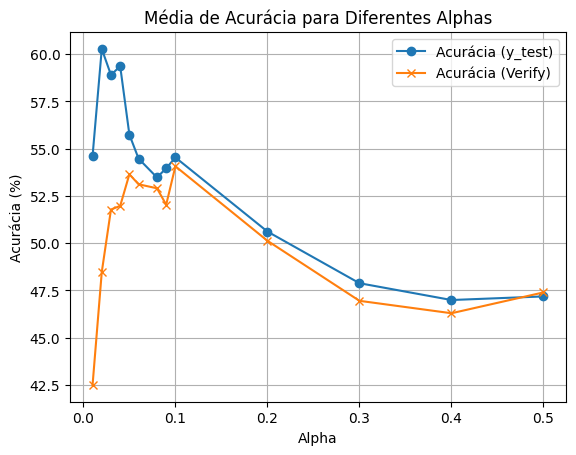

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound


# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por alpha
mean_accuracy_by_alpha = []

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse alpha
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por alpha
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_alpha.append((alpha, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para alpha {alpha}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para alpha {alpha}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for alpha, acc_ytest, acc_verify in mean_accuracy_by_alpha:
    print(f'Alpha: {alpha:.2f} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por alpha
import matplotlib.pyplot as plt

alphas, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_alpha)

plt.plot(alphas, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(alphas, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Alphas")
plt.xlabel('Alpha')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)

#### Time Series com verify

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar os resultados das acurácias
        all_accuracy_scores_ytest.append(accuracy_ytest)
        all_accuracy_scores_verify.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    print('---')

# Resultados gerais
print("Resumo geral:")
print(f'Média de acurácia (y_test): {np.mean(all_accuracy_scores_ytest):.2f}%')
print(f'Média de acurácia (Verify): {np.mean(all_accuracy_scores_verify):.2f}%')


Alpha: 0.1
Fold 1:
 - Correct Prediction (y_test): 60.90%
 - Correct Prediction (Verify): 49.16%
Fold 2:
 - Correct Prediction (y_test): 67.82%
 - Correct Prediction (Verify): 48.74%
Fold 3:
 - Correct Prediction (y_test): 61.64%
 - Correct Prediction (Verify): 40.67%
Fold 4:
 - Correct Prediction (y_test): 64.05%
 - Correct Prediction (Verify): 57.44%
Fold 5:
 - Correct Prediction (y_test): 70.65%
 - Correct Prediction (Verify): 51.57%
---
Alpha: 0.2
Fold 1:
 - Correct Prediction (y_test): 53.25%
 - Correct Prediction (Verify): 50.21%
Fold 2:
 - Correct Prediction (y_test): 59.22%
 - Correct Prediction (Verify): 55.24%
Fold 3:
 - Correct Prediction (y_test): 58.07%
 - Correct Prediction (Verify): 45.70%
Fold 4:
 - Correct Prediction (y_test): 58.60%
 - Correct Prediction (Verify): 55.45%
Fold 5:
 - Correct Prediction (y_test): 55.45%
 - Correct Prediction (Verify): 48.32%
---
Alpha: 0.3
Fold 1:
 - Correct Prediction (y_test): 49.37%
 - Correct Prediction (Verify): 48.22%
Fold 2:
 - Co

#### Time Series sem Verify

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X) e o target (Y) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y], axis=1).dropna()
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0,oob_score = True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Calcular e imprimir a acurácia para cada divisão
        accuracy = accuracy_score(y_test, y_pred) * 100.0
        print(f'Fold {fold}: Correct Prediction (%): {accuracy:.2f}')
        fold += 1

    print('---')


#### Salvando

In [ ]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

In [ ]:
price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/test_day.xlsx', index=False)